## Generate a regional grid

In [1]:
# by Niki Zadeh
# REF: https://github.com/nikizadehgfdl/grid_generation/blob/dev/jupynotebooks/regional_grid_spherical.ipynb

## helper routines and constants

In [2]:
#General imports and definitions
import cartopy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#Constants
PI_180 = np.pi/180.
_default_Re = 6.378e6


def mesh_plot(lon,lat, lon0=0.,lat0=90.):
    """Plot a given mesh with a perspective centered at (lon0,lat0)"""
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=lon0, central_latitude=lat0))
    ax.set_global()
    ax.stock_img()
    ax.coastlines()
    ax.gridlines()
    (nj,ni) = lon.shape 
    for i in range(0,ni+1,2):
        ax.plot(lon[:,i], lat[:,i], 'k', transform=cartopy.crs.Geodetic())
    for j in range(0,nj+1,2):
        ax.plot(lon[j,:], lat[j,:], 'k', transform=cartopy.crs.Geodetic())


def rotate_x(x,y,z,theta):
    """Rotate vector (x,y,z) by angle theta around x axis."""
    """Returns the rotated components."""
    cost = np.cos(theta)
    sint = np.sin(theta)
    yp   = y*cost - z*sint
    zp   = y*sint + z*cost
    return x,yp,zp

def rotate_y(x,y,z,theta):
    """Rotate vector (x,y,z) by angle theta around y axis."""
    """Returns the rotated components."""
    cost = np.cos(theta)
    sint = np.sin(theta)
    zp   = z*cost - x*sint
    xp   = z*sint + x*cost
    return xp,y,zp

def rotate_z(x,y,z,theta):
    """Rotate vector (x,y,z) by angle theta around z axis."""
    """Returns the rotated components."""
    cost = np.cos(theta)
    sint = np.sin(theta)
    xp   = x*cost - y*sint
    yp   = x*sint + y*cost
    return xp,yp,z


def cart2pol(x,y,z):
    """Transform a point on globe from Cartesian (x,y,z) to polar coordinates."""
    """Returns the polar coordinates"""
    lam = np.arctan2(y,x)/PI_180
    phi = np.arctan(z/np.sqrt(x**2+y**2))/PI_180
    return lam,phi

def pol2cart(lam,phi):
    """Transform a point on globe from Polar (lam,phi) to Cartesian coordinates."""
    """Returns the Cartesian coordinates"""
    lam = lam*PI_180
    phi = phi*PI_180
    x   = np.cos(phi)*np.cos(lam)
    y   = np.cos(phi)*np.sin(lam)
    z   = np.sin(phi)
    return x,y,z
    
def rotate_z_mesh(lam,phi,theta):
    """Rotate the whole mesh on globe by angle theta around z axis (globe polar axis)."""
    """Returns the rotated mesh."""
    #Bring the angle to be in [-pi,pi] so that atan2 would work
    lam=np.where(lam>180,lam-360,lam)
    #Change to Cartesian coord
    x,y,z=pol2cart(lam,phi)
    #Rotate
    xp,yp,zp=rotate_z(x,y,z,theta)
    #Change back to polar coords using atan2, in [-pi,pi]
    lamp,phip=cart2pol(xp,yp,zp)
    #Bring the angle back to be in [0,2*pi]
    lamp=np.where(lamp<0,lamp+360,lamp)
    return lamp,phip

def rotate_x_mesh(lam,phi,theta):
    """Rotate the whole mesh on globe by angle theta around x axis (passing through equator and prime meridian.)."""
    """Returns the rotated mesh."""
    #Bring the angle to be in [-pi,pi] so that atan2 would work
    lam=np.where(lam>180,lam-360,lam)
    #Change to Cartesian coord
    x,y,z=pol2cart(lam,phi)
    #Rotate
    xp,yp,zp=rotate_x(x,y,z,theta)
    #Change back to polar coords using atan2, in [-pi,pi]
    lamp,phip=cart2pol(xp,yp,zp)
    #Bring the angle back to be in [0,2*pi]
    lamp=np.where(lamp<0,lamp+360,lamp)
    return lamp,phip

def rotate_y_mesh(lam,phi,theta):
    """Rotate the whole mesh on globe by angle theta around y axis (passing through equator and prime meridian+90.)."""
    """Returns the rotated mesh."""
    #Bring the angle to be in [-pi,pi] so that atan2 would work
    lam=np.where(lam>180,lam-360,lam)
    #Change to Cartesian coord
    x,y,z=pol2cart(lam,phi)
    #Rotate
    xp,yp,zp=rotate_y(x,y,z,theta)
    #Change back to polar coords using atan2, in [-pi,pi]
    lamp,phip=cart2pol(xp,yp,zp)
    #Bring the angle back to be in [0,2*pi]
    lamp=np.where(lamp<0,lamp+360,lamp)
    return lamp,phip

def generate_latlon_mesh_centered(lni,lnj,llon0,llen_lon,llat0,llen_lat, ensure_nj_even=True):
    """Generate a regular lat-lon grid"""
    print('Generating regular lat-lon grid between centered at ', llon0, llat0)
    llonSP = llon0 - llen_lon/2 + np.arange(lni+1) * llen_lon/float(lni)
    llatSP = llat0 - llen_lat/2 + np.arange(lnj+1) * llen_lat/float(lnj)
    if(llatSP.shape[0]%2 == 0 and ensure_nj_even):
        print("   The number of j's is not even. Fixing this by cutting one row at south.")
        llatSP = np.delete(llatSP,0,0)
    llamSP = np.tile(llonSP,(llatSP.shape[0],1))
    lphiSP = np.tile(llatSP.reshape((llatSP.shape[0],1)),(1,llonSP.shape[0]))
    print('   generated regular lat-lon grid between latitudes ', lphiSP[0,0], lphiSP[-1,0])
    print('   number of js=', lphiSP.shape[0])
#    h_i_inv=llen_lon*PI_180*np.cos(lphiSP*PI_180)/lni
#    h_j_inv=llen_lat*PI_180*np.ones(lphiSP.shape)/lnj
#    delsin_j = np.roll(np.sin(lphiSP*PI_180),shift=-1,axis=0) - np.sin(lphiSP*PI_180)
#    dx_h=h_i_inv[:,:-1]*_default_Re
#    dy_h=h_j_inv[:-1,:]*_default_Re
#    area=delsin_j[:-1,:-1]*_default_Re*_default_Re*llen_lon*PI_180/lni
    return llamSP, lphiSP


def generate_regional_spherical(lon0,lon_span,lat0,lat_span,tilt,refine):
    """Generate a regional grid centered at (lon0,lat0) with spans of (lon_span,lat_span) and tilted by angle tilt"""
    Ni = int(lon_span*refine)
    Nj = int(lat_span*refine)
   
    #Generate a mesh at equator centered at (lon0, 0)
    lam_,phi_ = generate_latlon_mesh_centered(Ni, Nj, lon0, lon_span, 0.0, lat_span)
    lam_,phi_=rotate_z_mesh(lam_,phi_, (90.-lon0)*PI_180)  #rotate around z to bring it centered at y axis
    lam_,phi_=rotate_y_mesh(lam_,phi_,tilt*PI_180)         #rotate around y axis to tilt it as desired
    lam_,phi_=rotate_x_mesh(lam_,phi_,lat0*PI_180)         #rotate around x to bring it centered at (lon0,lat0)
    lam_,phi_=rotate_z_mesh(lam_,phi_,-(90.-lon0)*PI_180)  #rotate around z to bring it back 
    return lam_,phi_
    


### Let's say we want to generate a regional (super)grid with a nominal resolution  of 1 degrees with the center at (lon,lat)=(230,40) spaning 20 and 30 degrees east and north. Also we want it skewed to go along the coast.


Generating regular lat-lon grid between centered at  230.0 0.0
   generated regular lat-lon grid between latitudes  -15.0 15.0
   number of js= 31


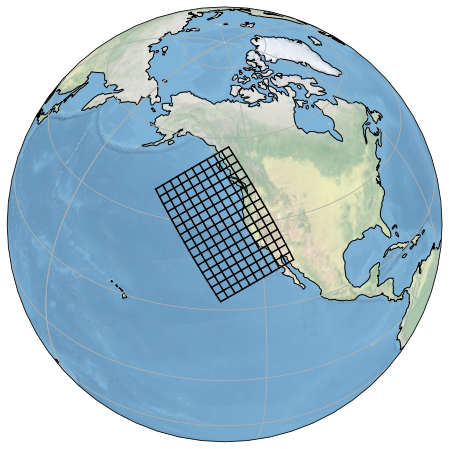

In [3]:
# What happens if refineS = 1?
# Specify the grid properties
# All
# Specify the desired resolution
refineR  = 1 # Inverse of nominal resolution
refineS  = 1 # What happens?
lon_span = 20.
lat_span = 30.

lon0 = 230.0 
lat0 = 40.0
tilt = 30.0

lamc,phic = generate_regional_spherical(lon0, lon_span, lat0, lat_span, tilt, refineR*refineS)  

mesh_plot(lamc, phic, lon0, lat0)    


Generating regular lat-lon grid between centered at  230.0 0.0
   generated regular lat-lon grid between latitudes  -15.0 15.0
   number of js= 61


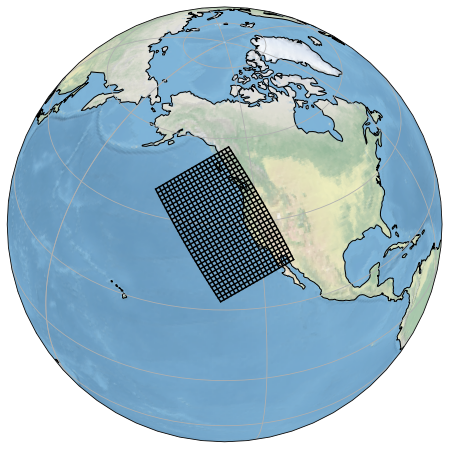

In [4]:
# Specify the grid properties
# All
# Specify the desired resolution
refineR  = 1 # Inverse of nominal resolution
refineS  = 2 # Set to 2 for supergrid
lon_span = 20.
lat_span = 30.

lon0 = 230.0 
lat0 = 40.0
tilt = 30.0

lamc,phic = generate_regional_spherical(lon0, lon_span, lat0, lat_span, tilt, refineR*refineS)  

mesh_plot(lamc, phic, lon0, lat0)    

### Regular grid covering the northern ocean


Generating regular lat-lon grid between centered at  210.0 0.0
   generated regular lat-lon grid between latitudes  -30.0 30.0
   number of js= 121


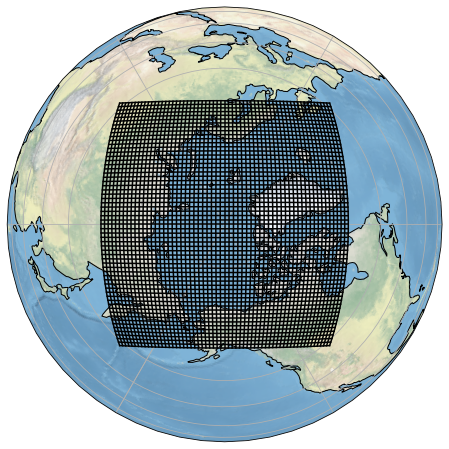

In [5]:
lon_span=60.
lat_span=60.
lon0=210.0 
lat0=90.0
tilt=0.0

lamc,phic= generate_regional_spherical(lon0,lon_span,lat0,lat_span,tilt,refineR*refineS)    
mesh_plot(lamc,phic, lon0,lat0)    

### Food for thought: Rotation around a general axis along a given vector (ux,uy,uz)

Generating regular lat-lon grid between centered at  230.0 40.0
   generated regular lat-lon grid between latitudes  25.0 55.0
   number of js= 61


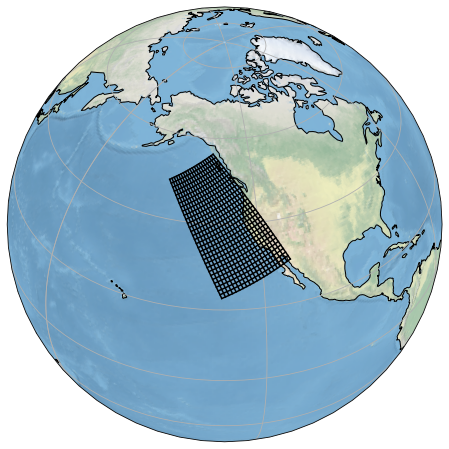

In [6]:
def rotate_u(x,y,z,ux,uy,uz,theta):
    """Rotate by angle θ around a general axis (ux,uy,uz).￼"""
    c=np.cos(theta)
    s=np.sin(theta)
    
    #Normalize, u must be a unit vector for this to work
    unorm=np.sqrt(ux*ux+uy*uy+uz*uz)
    ux=ux/unorm
    uy=uy/unorm
    uz=uz/unorm
    
    r11=c+(1-c)*ux*ux 
    r22=c+(1-c)*uy*uy 
    r33=c+(1-c)*uz*uz 
    
    r12=(1-c)*ux*uy-s*uz 
    r21=(1-c)*ux*uy+s*uz 
    
    r13=(1-c)*ux*uz+s*uy
    r31=(1-c)*ux*uz-s*uy
    
    r23=(1-c)*uy*uz-s*ux
    r32=(1-c)*uy*uz+s*ux
    
    xp= r11*x+r12*y+r13*z
    yp= r21*x+r22*y+r23*z
    zp= r31*x+r32*y+r33*z
    return xp,yp,zp

def rotate_u_mesh(lam,phi,ux,uy,uz,theta):
    #Bring the angle to be in [-pi,pi] so that atan2 would work
    lam=np.where(lam>180,lam-360,lam)
    #Change to Cartesian coord
    x,y,z=pol2cart(lam,phi)
    #Rotate
    xp,yp,zp=rotate_u(x,y,z,ux,uy,uz,theta)
    #Change back to polar coords using atan2, in [-pi,pi]
    lamp,phip=cart2pol(xp,yp,zp)
    #Bring the angle back to be in [0,2*pi]
    lamp=np.where(lamp<0,lamp+360,lamp)
    return lamp,phip


def generate_rotated_grid(lon0,lon_span,lat0,lat_span,tilt,refine):
    Ni = int(lon_span*refine)
    Nj = int(lat_span*refine)
   
    #Generate a mesh at equator centered at (lon0, lat0)
    lam_,phi_ = generate_latlon_mesh_centered(Ni,Nj,lon0,lon_span,lat0,lat_span)
    ux,uy,uz=pol2cart(lon0,lat0)
    lam_,phi_=rotate_u_mesh(lam_,phi_, ux,uy,uz, tilt*PI_180)  #rotate mesh around u by theta
    return lam_,phi_

lon_span=20.
lat_span=30.
lon0=230.0 
lat0=40.0
tilt=30

lamc,phic= generate_rotated_grid(lon0,lon_span,lat0,lat_span,tilt,refineR*refineS)  

mesh_plot(lamc,phic, lon0,lat0)    

In [7]:
#translation vector: the new location of grid
def translate_mesh(lam,phi, x0,y0,z0):
    #Bring the angle to be in [-pi,pi] so that atan2 would work
    lam=np.where(lam>180,lam-360,lam)
    #Change to Cartesian coord
    x,y,z=pol2cart(lam,phi)
    #Translate
    #(0,0,1) --> (x0,y0,z0)
    #So
    #(x,y,z) --> (x+x0,y+y0,z+z0-1)
    xp,yp,zp=x+x0-x[0,0],y+y0-y[0,0],z+z0-z[0,0]
    #Change back to polar coords using atan2, in [-pi,pi]
    lamp,phip=cart2pol(xp,yp,zp)
    #Bring the angle back to be in [0,2*pi]
    lamp=np.where(lamp<0,lamp+360,lamp)
    return lamp,phip